<h1 style="text-align: center; font-size: 50px;"> Handwritten digit classification with keras MLflow integration </h1>

Notebook Overview
- Start Execution
- User Constants 
- Install and Import Libraries
- Configure Settings
- Logging Model to MLflow
- Fetching the Latest Model Version from MLflow
- Loading the Model and Running Inference


## Start Execution

In [1]:
import logging
import time

# Configure logger
logger: logging.Logger = logging.getLogger("register_model_logger")
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent duplicate logs from parent loggers

# Set formatter
formatter: logging.Formatter = logging.Formatter(
    fmt="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Configure and attach stream handler
stream_handler: logging.StreamHandler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [2]:
start_time = time.time()  

logger.info("Notebook execution started.")

2025-07-24 18:09:47 - INFO - Notebook execution started.


## User Constants

In [3]:
DIGIT_BASE64 = "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+prW0uL66itbSCSe4lbbHFEpZmPoAOtaWt+FtZ8Ox28mqWghS4LCNlmSQblxuU7GO1huGQcHnpWPRXoOiWF/pfhiwh0K2ln8R+JfMWNoh89vaK2w7f7pdg2Wzwq9sk1X+IY03SItJ8JabMLk6QsjX1wpOJLuQr5gHsuxQP/rVw1Fen+EfFmueF/AN3qkup3C2yMbPR7QkBXmbJkk9SsYOcfd3MK8yd3lkaSRizsSzMxyST1JptFXLnVb280+ysJ5y9rYhxbx4AEe9tzdBzk9z7elU6K//2Q=="

## Install and Import Libraries

In [4]:
from PIL import Image
import base64
from io import BytesIO
import warnings                         
import logging  


import numpy as np
import pandas as pd  

import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

# ------------------------ MLflow Integration ------------------------
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

2025-07-24 18:09:56.425607: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 18:09:57.747105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753380598.141006     401 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753380598.244169     401 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 18:09:59.366493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Configure Settings

In [5]:
# ------------------------- MLflow Experiment Configuration -------------------------
EXPERIMENT_NAME = 'MNIST with TensorFlow'
RUN_NAME = "MNIST_Run"
MODEL_NAME = "MNIST_Model"
MODEL_PATH = "model_keras_mnist.keras"

In [6]:
# Suppress Python warnings
warnings.filterwarnings("ignore")

## Logging Model to MLflow

In [7]:
class MNISTModel(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        """
        Load model from artifacts.
        """
        try:
            import tensorflow as tf
            # Load the model from artifacts
            self.model = tf.keras.models.load_model(context.artifacts["mnist_model"])

        except Exception as e:
            logger.error(f"Error loading context: {str(e)}")
            raise

    def predict(self, context, model_input, params=None):
        """
        Computes the predicted digit, by converting the base64 to a numpy array.
        """
        try:
            if isinstance(model_input, pd.DataFrame):
                image_input = model_input.iloc[0, 0]
            elif isinstance(model_input, list):
                image_input = model_input[0]
            else:
                image_input = str(model_input)
                
            base64_array = base64_to_numpy(image_input)

            predictions = self.model.predict(base64_array)
            predicted_classes = np.argmax(predictions, axis=1)
            
            return predicted_classes.tolist()
        
        except Exception as e:
            logger.error(f"Error performing prediction: {str(e)}")
            raise
    
    @classmethod
    def log_model(cls, model_name, config_path="../configs/config.yaml"):
        """
        Logs the model to MLflow with appropriate artifacts and schema.
        """
        try:
            # Define input and output schema
            input_schema = Schema([
                ColSpec("string", name="digit"),
            ])
            output_schema = Schema([
                ColSpec("long", name="prediction"),
            ])
            
            # Define model signature
            signature = ModelSignature(inputs=input_schema, outputs=output_schema)
            
            # Save the model
            model.save(MODEL_PATH)
            
            # Log the model in MLflow
            mlflow.pyfunc.log_model(
                artifact_path=model_name,
                python_model=cls(),
                artifacts={
                    "mnist_model": MODEL_PATH,
                    "config": config_path
                },
                signature=signature,
                pip_requirements=[
                    "tensorflow>=2.0.0",
                    "numpy",
                    "pillow",
                ]
            )

        except Exception as e:
            logger.error(f"Error logging model: {str(e)}")
            raise

/opt/conda/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [8]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_cat_train, epochs=4, validation_data=(x_test, y_cat_test))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1753380619.978322     401 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46708 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:2d:00.0, compute capability: 7.5
I0000 00:00:1753380619.989995     401 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46709 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:99:00.0, compute capability: 7.5


Epoch 1/4


I0000 00:00:1753380626.421427     630 service.cc:148] XLA service 0x7feb30017f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753380626.429644     630 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1753380626.429762     630 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-07-24 18:10:26.670899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753380627.091041     630 cuda_dnn.cc:529] Loaded cuDNN version 90300


  26/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4945 - loss: 1.6511

I0000 00:00:1753380631.315876     630 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.9188 - loss: 0.2652 - val_accuracy: 0.9832 - val_loss: 0.0516
Epoch 2/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9863 - loss: 0.0460 - val_accuracy: 0.9792 - val_loss: 0.0636
Epoch 3/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9907 - loss: 0.0287 - val_accuracy: 0.9896 - val_loss: 0.0338
Epoch 4/4
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9935 - loss: 0.0203 - val_accuracy: 0.9870 - val_loss: 0.0431


In [9]:
def base64_to_numpy(base64_string):
    """
    Convert base64 string to numpy array for MNIST digit prediction.
    """
    try:
        # Decode the base64 string
        image_data = base64.b64decode(base64_string)
        
        # Open the image using PIL
        image = Image.open(BytesIO(image_data))
        
        # Convert to grayscale if not already
        if image.mode != 'L':
            image = image.convert('L')
        
        # Resize to 28x28 if needed
        if image.size != (28, 28):
            image = image.resize((28, 28))
        
        # Convert to numpy array
        numpy_array = np.array(image)
        
        # Normalize pixel values to 0-1 range
        numpy_array = numpy_array.astype('float32') / 255.0
        
        # Reshape for model input (1, 28, 28, 1)
        numpy_array = numpy_array.reshape(1, 28, 28, 1)
        
        return numpy_array
        
    except Exception as e:
        logger.error(f"Error converting base64 to numpy: {str(e)}")
        raise

In [10]:
logger.info(f'Starting the experiment: {EXPERIMENT_NAME}')

mlflow.set_tracking_uri('/phoenix/mlflow')
# Set the MLflow experiment name
mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

# Start an MLflow run
with mlflow.start_run(run_name=RUN_NAME) as run:
    # Print the artifact URI for reference
    logging.info(f"Run's Artifact URI: {run.info.artifact_uri}")
    test_loss, test_accuracy = model.evaluate(x_test, y_cat_test, verbose=0)
    mlflow.log_metrics({"test_accuracy": test_accuracy})
    mlflow.log_metrics({"test_loss": test_loss})

    # Log the model to MLflow
    MNISTModel.log_model(model_name=MODEL_NAME, config_path="../configs/config.yaml")

    # Log demo artifacts for deployment
    mlflow.log_artifacts("../demo/", artifact_path="demo")

    # Register the logged model in MLflow Model Registry
    mlflow.register_model(
        model_uri=f"runs:/{run.info.run_id}/{MODEL_NAME}", 
        name=MODEL_NAME
    )

logger.info(f'Registered the model: {MODEL_NAME}')

2025-07-24 18:12:10 - INFO - Starting the experiment: MNIST with TensorFlow
2025/07/24 18:12:10 INFO mlflow.tracking.fluent: Experiment with name 'MNIST with TensorFlow' does not exist. Creating a new experiment.


Successfully registered model 'MNIST_Model'.
Created version '1' of model 'MNIST_Model'.
2025-07-24 18:12:22 - INFO - Registered the model: MNIST_Model


## Fetching the Latest Model Version from MLflow

In [11]:
# Initialize the MLflow client
client = MlflowClient()

# Retrieve the latest version of the model
model_metadata = client.get_latest_versions(MODEL_NAME, stages=["None"])
latest_model_version = model_metadata[0].version  # Extract the latest model version

# Fetch model information, including its signature
model_info = mlflow.models.get_model_info(f"models:/{MODEL_NAME}/{latest_model_version}")

# Print the latest model version and its signature
logger.info(f"Latest Model Version: {latest_model_version}")
logger.info(f"Model Signature: {model_info.signature}")

2025-07-24 18:12:23 - INFO - Latest Model Version: 1
2025-07-24 18:12:23 - INFO - Model Signature: inputs: 
  ['digit': string (required)]
outputs: 
  ['prediction': long (required)]
params: 
  None



## Loading the Model and Running Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


2025-07-24 18:12:24 - INFO - Predicted class: [9]


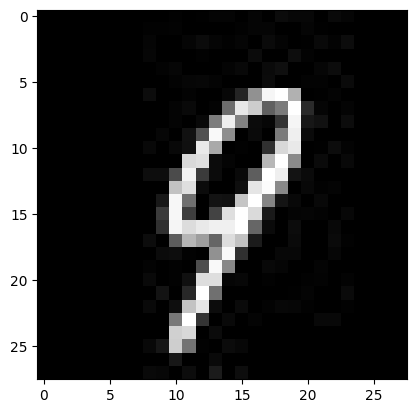

In [12]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/{MODEL_NAME}/{latest_model_version}")

# Base64 example
base = DIGIT_BASE64
numpy_image = base64_to_numpy(base)
# Image of the base64 example
plt.imshow(numpy_image.squeeze(), cmap= 'gray') 

base_input = pd.DataFrame({"digit": [base]})
# Prediction of base64
predictions = model.predict(base_input)

logger.info(f"Predicted class: {predictions}")

In [13]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

2025-07-24 18:12:24 - INFO - ⏱️ Total execution time: 2m 37.58s
2025-07-24 18:12:24 - INFO - ✅ Notebook execution completed successfully.


Built with ❤️ using [**Z by HP AI Studio**](https://zdocs.datascience.hp.com/docs/aistudio/overview).